In [15]:
import os, pathlib, numpy as np, matplotlib.pyplot as plt, warnings
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [16]:
#tf.config.optimizer.set_experimental_options({'layout_optimizer': False})

### ***Constants & File Path***

In [17]:
SEED = 58
IMG_SIZE = (160, 160)
BATCH_SIZE = 32
DATA_DIR = "/kaggle/input/combined-forest-fire/combined_data/train"
TEST_DIR = "/kaggle/input/combined-forest-fire/combined_data/test"
VAL_SPLIT = 0.2
AUTOTUNE = tf.data.AUTOTUNE

tf.random.set_seed(SEED)
np.random.seed(SEED)

### ***Dataset Creation (train/val split)***

In [18]:
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.data import experimental as tfdata_exp

train_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=VAL_SPLIT,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode="rgb"
)
val_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=VAL_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode="rgb"
)

class_names = train_ds.class_names

test_ds = image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, color_mode="rgb",
    shuffle=False,               
    class_names=class_names        
)

NUM_CLASSES = len(class_names)
print("classes:", class_names)

train_ds = train_ds.apply(tfdata_exp.ignore_errors())
val_ds = val_ds.apply(tfdata_exp.ignore_errors())
test_ds = test_ds.apply(tfdata_exp.ignore_errors())

Found 20620 files belonging to 2 classes.
Using 16496 files for training.
Found 20620 files belonging to 2 classes.
Using 4124 files for validation.
Found 2935 files belonging to 2 classes.
classes: ['fire', 'nonfire']


### ***Sample Classes and Data Distribution***

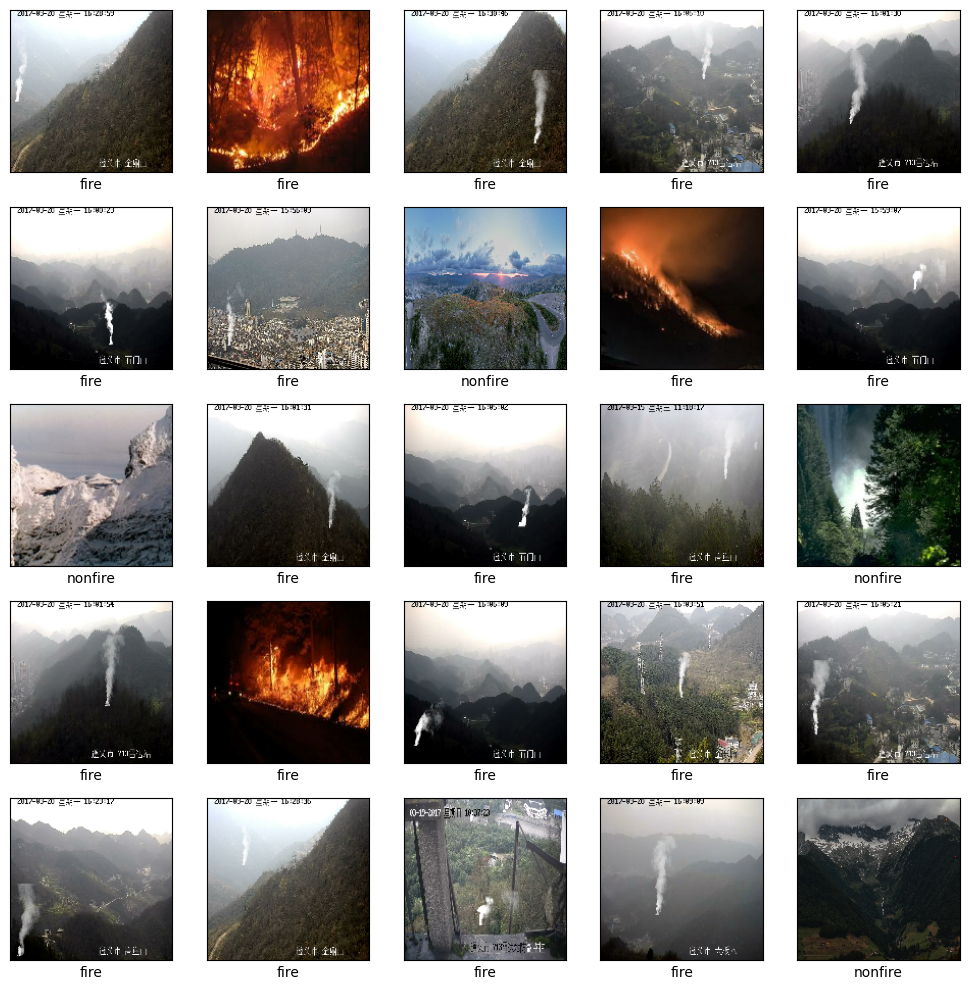

In [19]:
for batch_images, batch_labels in train_ds.take(1):
    imgs = batch_images[:25].numpy()   # (25,H,W,C)
    labs = batch_labels[:25].numpy()   # (25,)

plt.figure(figsize=(10,10))
for i in range(len(imgs)):
    plt.subplot(5,5,i+1)
    plt.xticks([]); plt.yticks([]); plt.grid(False)
    plt.imshow(imgs[i].astype(np.uint8)) 
    plt.xlabel(class_names[int(labs[i])])
plt.tight_layout(); plt.show()

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


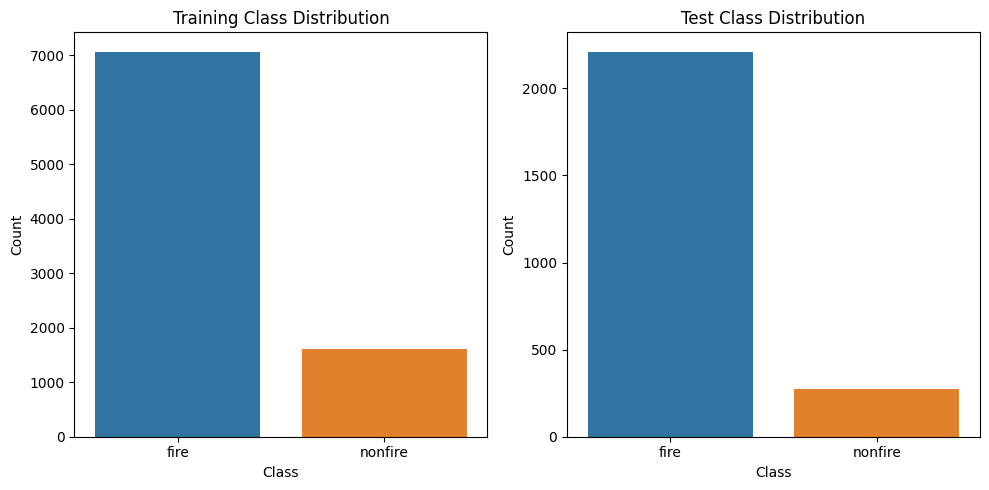

In [20]:
import seaborn as sns
def class_counts(ds, num_classes):
    counts = np.zeros(num_classes, dtype=np.int64)
    for _, y in ds.unbatch():           # y: scalar (sparse label)
        counts[int(y.numpy())] += 1
    return counts

train_counts = class_counts(train_ds, NUM_CLASSES)
test_counts  = class_counts(test_ds, NUM_CLASSES)  

fig = plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.barplot(x=class_names, y=train_counts)
plt.title("Training Class Distribution")
plt.xlabel("Class"); plt.ylabel("Count")

plt.subplot(1,2,2)
sns.barplot(x=class_names, y=test_counts)
plt.title("Test Class Distribution")
plt.xlabel("Class"); plt.ylabel("Count")

plt.tight_layout(); plt.show()

### ***Optimization & Data Augmentation***

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

train_ds = train_ds.shuffle(1024).prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="augmentation")

### ***Building Baseline***


In [22]:
def build_baseline(input_shape=IMG_SIZE+(3,), num_classes=NUM_CLASSES):
    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)

    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="fire_predict")
    return model

model = build_baseline()
model.summary()

Model: "fire_predict"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 160, 160, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 80, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 40, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,647,234 (25.36 MB)

 Trainable params: 6,647,234 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### ***Compiling, Callbacks and Model Training***

In [23]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy"),
    keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, monitor="val_loss"),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(train_ds, validation_data=val_ds, epochs=12,callbacks=callbacks)

model.evaluate(test_ds, verbose=1)

Epoch 1/12


E0000 00:00:1758909428.964093      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/fire_predict_1/dropout_2_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
Invalid SOS parameters for sequential JPEG


    261/Unknown 121s 44ms/step - accuracy: 0.8574 - loss: 0.4211

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


262/262 ━━━━━━━━━━━━━━━━━━━━ 149s 152ms/step - accuracy: 0.8577 - loss: 0.4198 - val_accuracy: 0.9303 - val_loss: 0.1658 - learning_rate: 0.0010
Epoch 2/12


Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


262/262 ━━━━━━━━━━━━━━━━━━━━ 145s 150ms/step - accuracy: 0.9289 - loss: 0.1725 - val_accuracy: 0.9424 - val_loss: 0.1544 - learning_rate: 0.0010
Epoch 3/12


Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


262/262 ━━━━━━━━━━━━━━━━━━━━ 151s 151ms/step - accuracy: 0.9363 - loss: 0.1511 - val_accuracy: 0.9333 - val_loss: 0.1574 - learning_rate: 0.0010
Epoch 4/12


Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


262/262 ━━━━━━━━━━━━━━━━━━━━ 144s 141ms/step - accuracy: 0.9384 - loss: 0.1525 - val_accuracy: 0.9458 - val_loss: 0.1621 - learning_rate: 0.0010
Epoch 5/12


Invalid SOS parameters for sequential JPEG


262/262 ━━━━━━━━━━━━━━━━━━━━ 142s 140ms/step - accuracy: 0.9535 - loss: 0.1233 - val_accuracy: 0.9484 - val_loss: 0.1387 - learning_rate: 5.0000e-04
Epoch 6/12


Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


262/262 ━━━━━━━━━━━━━━━━━━━━ 146s 142ms/step - accuracy: 0.9456 - loss: 0.1225 - val_accuracy: 0.9480 - val_loss: 0.1226 - learning_rate: 5.0000e-04
Epoch 7/12


Invalid SOS parameters for sequential JPEG


262/262 ━━━━━━━━━━━━━━━━━━━━ 144s 140ms/step - accuracy: 0.9509 - loss: 0.1140 - val_accuracy: 0.9474 - val_loss: 0.1365 - learning_rate: 5.0000e-04
Epoch 8/12


Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


262/262 ━━━━━━━━━━━━━━━━━━━━ 139s 138ms/step - accuracy: 0.9538 - loss: 0.1100 - val_accuracy: 0.9560 - val_loss: 0.1050 - learning_rate: 5.0000e-04
Epoch 9/12


Invalid SOS parameters for sequential JPEG


262/262 ━━━━━━━━━━━━━━━━━━━━ 144s 143ms/step - accuracy: 0.9563 - loss: 0.1028 - val_accuracy: 0.9618 - val_loss: 0.0945 - learning_rate: 5.0000e-04
Epoch 10/12


Invalid SOS parameters for sequential JPEG


262/262 ━━━━━━━━━━━━━━━━━━━━ 147s 143ms/step - accuracy: 0.9595 - loss: 0.0996 - val_accuracy: 0.9533 - val_loss: 0.1147 - learning_rate: 5.0000e-04
Epoch 11/12


Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


262/262 ━━━━━━━━━━━━━━━━━━━━ 145s 143ms/step - accuracy: 0.9598 - loss: 0.1014 - val_accuracy: 0.9436 - val_loss: 0.1595 - learning_rate: 5.0000e-04
Epoch 12/12


Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


262/262 ━━━━━━━━━━━━━━━━━━━━ 147s 147ms/step - accuracy: 0.9691 - loss: 0.0804 - val_accuracy: 0.9559 - val_loss: 0.1268 - learning_rate: 2.5000e-04
78/78 ━━━━━━━━━━━━━━━━━━━━ 36s 449ms/step - accuracy: 0.8945 - loss: 0.2573


NameError: name 'time' is not defined

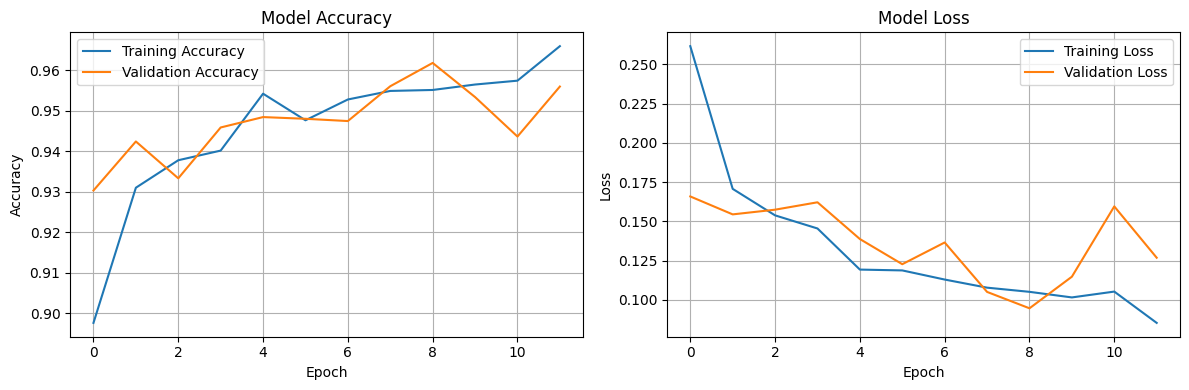

78/78 ━━━━━━━━━━━━━━━━━━━━ 35s 439ms/step - accuracy: 0.8945 - loss: 0.2573


[0.211745485663414, 0.9155609011650085]

In [24]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
model.evaluate(test_ds, verbose=1)

### ***Model Saving (if needed)***

In [ ]:
model.save("/kaggle/working/my_model.h5")
#model.save_weights("/kaggle/working/my_model.weights.h5")

### ***Predict a Single Image***

In [29]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np, pathlib

def predict_image(img_path, model, img_size=IMG_SIZE, class_names=class_names):
    img = load_img(img_path, target_size=img_size, color_mode="rgb")
    arr = img_to_array(img)              # (H,W,3), dtype=float32, 0..255
    arr = np.expand_dims(arr, axis=0)    # (1,H,W,3)

    # Tahmin
    probs = model.predict(arr, verbose=0)[0]          # (num_classes,)
    idx   = int(np.argmax(probs))
    pred  = class_names[idx]
    conf  = float(probs[idx])

    return {"path": str(img_path), "pred": pred, "conf": conf, "probs": probs}

TEST_IMG = "/kaggle/input/testtest/testdata/nonfiretest/NF_9.jpg"
res = predict_image(TEST_IMG, model)
print(f"Pred: {res['pred']}  |  conf: {res['conf']:.3f}")

Pred: nonfire  |  conf: 0.959


In [ ]:
model.save_weights("/kaggle/working/fire_nonfire.weights.h5")

### ***Model Evaluation***

Evaluate -> {'loss': 0.211745485663414, 'compile_metrics': 0.9155609011650085}

Classification Report:
              precision    recall  f1-score   support

        fire       0.97      0.94      0.95      2211
     nonfire       0.60      0.75      0.66       276

    accuracy                           0.92      2487
   macro avg       0.78      0.84      0.81      2487
weighted avg       0.93      0.92      0.92      2487



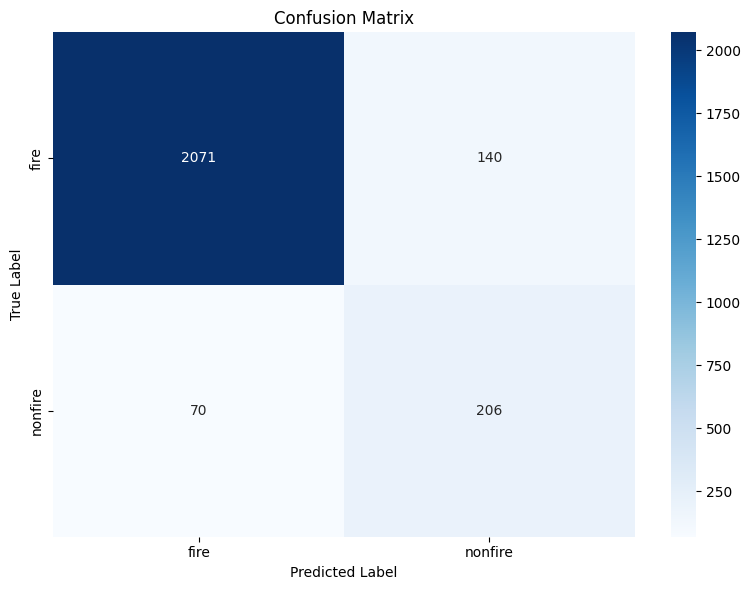

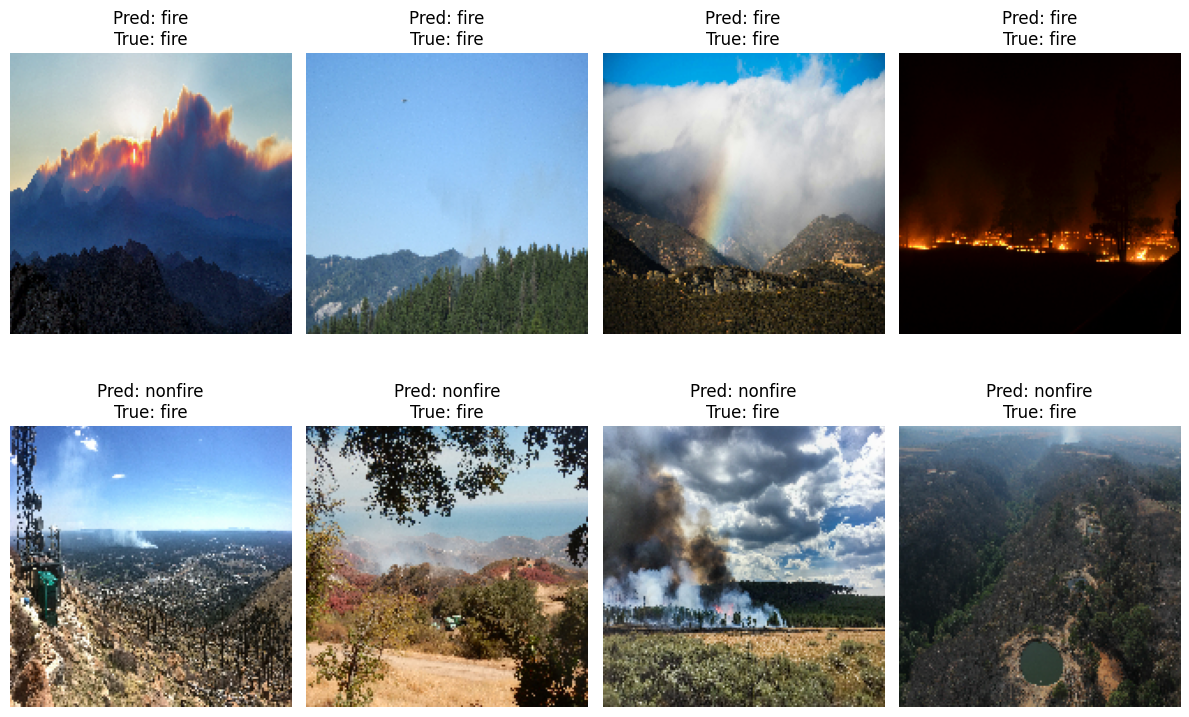

In [32]:
from sklearn.metrics import classification_report, confusion_matrix
test_results = model.evaluate(test_ds, verbose=0)
print("Evaluate ->", dict(zip(model.metrics_names, [float(x) for x in np.atleast_1d(test_results)])))

y_true_list, y_prob_list = [], []
x_vis_batches = []  # görselleştirme için sınırlı sayıda batch saklama

for x_batch, y_batch in test_ds:
    probs = model.predict(x_batch, verbose=0)
    y_prob_list.append(probs)
    y_true_list.append(y_batch.numpy())
    if len(x_vis_batches) < 4:  
        x_vis_batches.append(x_batch.numpy())

y_true = np.concatenate(y_true_list, axis=0)
y_prob = np.vstack(y_prob_list)

if y_prob.ndim == 1 or y_prob.shape[1] == 1:
    y_pred_classes = (y_prob.ravel() > 0.5).astype(int)
else:
    y_pred_classes = np.argmax(y_prob, axis=1)

#Sınıflandırma raporu
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

#Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

X_vis = np.concatenate(x_vis_batches, axis=0)

y_true_vis = []
for _, yb in test_ds.unbatch().take(len(X_vis)):
    y_true_vis.append(int(yb.numpy()))
y_true_vis = np.array(y_true_vis[:len(X_vis)])  # güvenlik

probs_vis = model.predict(X_vis, verbose=0)
if probs_vis.ndim == 1 or probs_vis.shape[1] == 1:
    y_pred_vis = (probs_vis.ravel() > 0.5).astype(int)
else:
    y_pred_vis = np.argmax(probs_vis, axis=1)

correct_idx   = np.where(y_pred_vis == y_true_vis)[0]
incorrect_idx = np.where(y_pred_vis != y_true_vis)[0]

plt.figure(figsize=(12, 8))
# Doğru tahminlerden 4 örnek
for i, idx in enumerate(correct_idx[:4]):
    plt.subplot(2, 4, i+1)
    plt.imshow(X_vis[idx].astype(np.uint8))
    plt.title(f"Pred: {class_names[y_pred_vis[idx]]}\nTrue: {class_names[y_true_vis[idx]]}")
    plt.axis('off')

# Yanlış tahminlerden 4 örnek
for i, idx in enumerate(incorrect_idx[:4]):
    plt.subplot(2, 4, i+5)
    plt.imshow(X_vis[idx].astype(np.uint8))
    plt.title(f"Pred: {class_names[y_pred_vis[idx]]}\nTrue: {class_names[y_true_vis[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()